# **TRAINING**

### Initial configurations

In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

E0000 00:00:1732388979.582078      77 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1123 19:09:39.589980724      77 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1123 19:09:39.589996237      77 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1123 19:09:39.589999496      77 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1123 19:09:39.590001892      77 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1123 19:09:39.590004195      77 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

In [3]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

### Set accelerator

In [4]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [5]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1732389015.613290      77 service.cc:145] XLA service 0x563b33e04b30 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732389015.613343      77 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732389015.613347      77 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732389015.613350      77 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732389015.613352      77 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732389015.613355      77 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732389015.613358      77 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732389015.613360      77 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732389015.613363      77 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Running on TPU: 
Running on 8 replicas
Num GPUs Available:  0
Num TPUs Available:  8


In [6]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256


## **DATA PREPROCESSING**

In [7]:
train_path = "/kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz"
val_path = "/kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz"
print(f"reading {train_path}")
print(f"reading {val_path}")

reading /kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz
reading /kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz


In [8]:
data_train = np.load(train_path, allow_pickle=True)
X_train = data_train['images']
y_train = data_train['labels']

data_val = np.load(val_path, allow_pickle=True)
X_val = data_val['images']
y_val = data_val['labels']

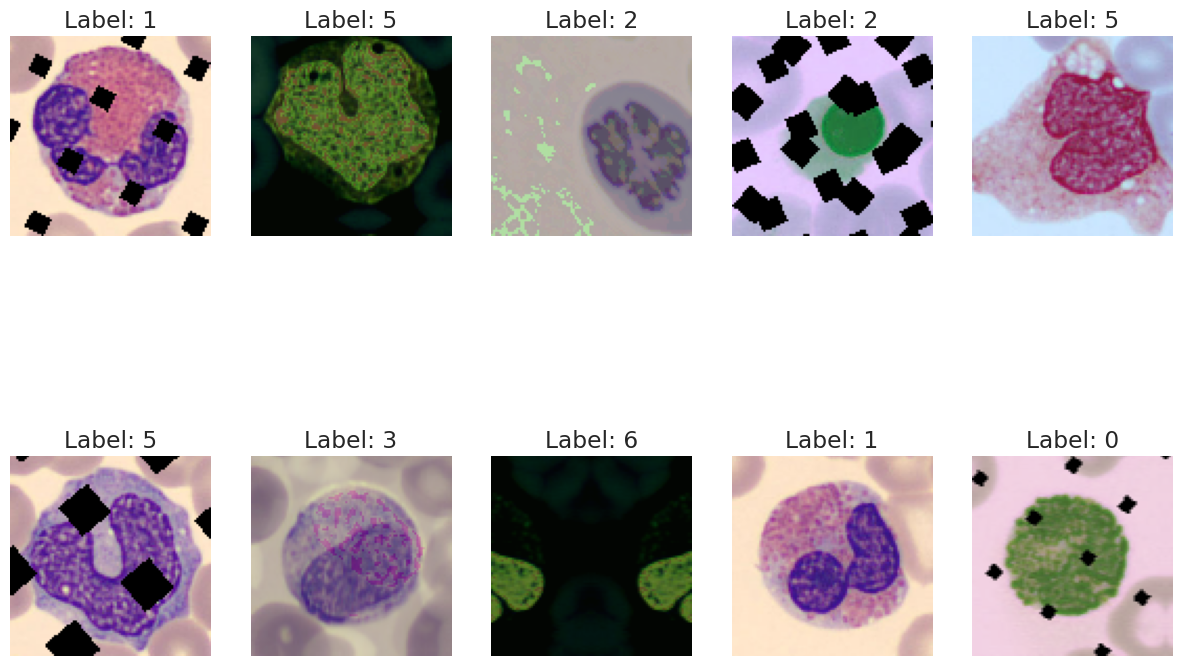

In [9]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[random_idx])
    plt.title(f"Label: {np.argmax(y_train[random_idx])}")
    plt.axis('off')
plt.show()

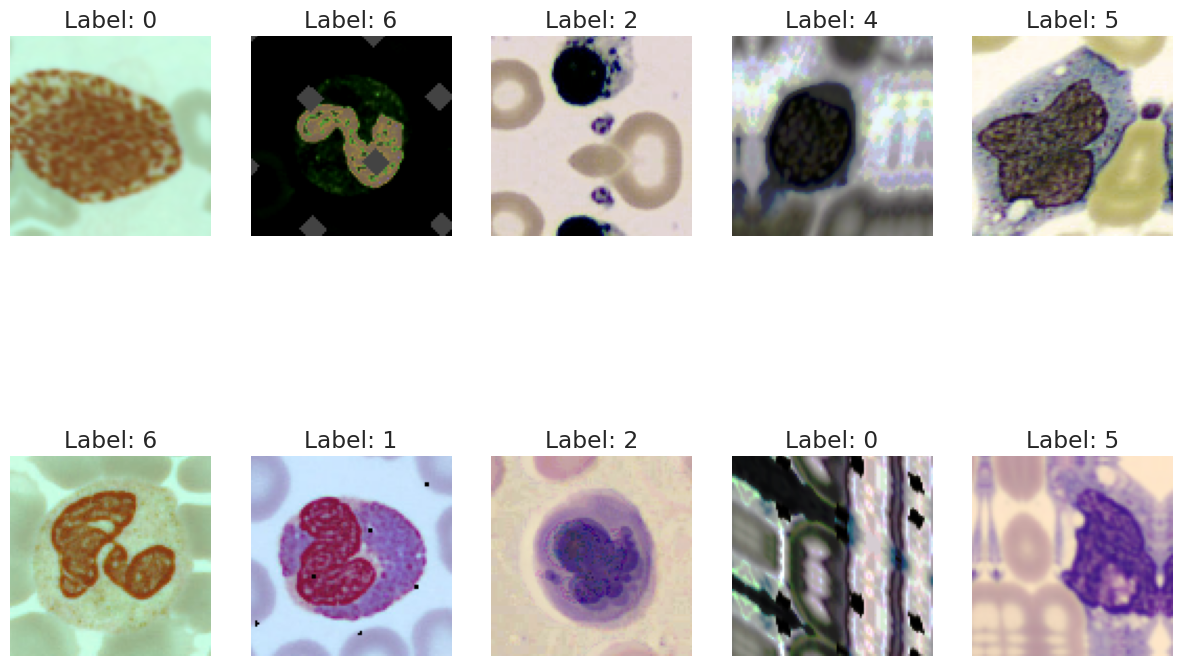

In [10]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_val.shape[0])
    plt.imshow(X_val[random_idx])
    plt.title(f"Label: {np.argmax(y_val[random_idx])}")
    plt.axis('off')
plt.show()

In [11]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (91431, 96, 96, 3)
Training Label Shape: (91431, 8)
Validation Data Shape: (16137, 96, 96, 3)
Validation Label Shape: (16137, 8)


In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(65536).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Custom callbacks

In [13]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [14]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [15]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

### Model definition

In [16]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  357


In [17]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

@register_keras_serializable()
class CustomAugmentLayer(tfk.layers.Layer):
    def __init__(self, max_rotation=30.0, max_zoom=0.2, **kwargs):
        super(CustomAugmentLayer, self).__init__(**kwargs)
        self.max_rotation = max_rotation / 360.0
        self.max_zoom = max_zoom
        
    def call(self, inputs, training=False):
        if training:
            inputs = tf.image.random_flip_up_down(tf.image.random_flip_left_right(inputs))
        return inputs


In [18]:
def build_model(
            shape=input_shape, 
            n_labels=output_shape, 
            base_model_trainable=False, #standard definitions
            n_dense_layers=1, 
            initial_dense_neurons=1024, 
            min_neurons=64, # architecture definitions
            include_dropout=True, 
            dropout_rate=0.3, 
            l2_lambda=4e-3, # against overfitting
            learning_rate=1e-3,
            mult_next_layer = 1/2,
            include_batch_normalization = True):
    
    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')   
    
    # The two augmentation layers
    x = CustomCastLayer()(inputs)
    x = CustomAugmentLayer()(x, training=True)

    # The convnext layer with include top=False to take the convolutional part only
    base_model = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    base_model.trainable = base_model_trainable

    x = base_model(x)
    x = tfkl.BatchNormalization(name="BatchNorm_After_ConvNeXt")(x) if include_batch_normalization else x # BatchNorm after ConvNeXt
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation=None, name=f'Dense_layer_{k}', 
                       kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        x = tfkl.BatchNormalization(name=f'BatchNorm_Dense_layer_{k}')(x) if include_batch_normalization else x   # BatchNorm in dense layer
        x = tfkl.Activation('silu', name=f'Activation_layer_{k}')(x)  # Apply activation after BatchNorm
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = int(neurons * mult_next_layer)

    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalFocalCrossentropy(
                                                alpha=0.25,
                                                gamma=2.0,
                                                from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="sum_over_batch_size",
                                                name="categorical_focal_crossentropy",
                                                dtype=None,
                                            )
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tf.keras.optimizers.AdamW(
                                learning_rate=learning_rate,
                                weight_decay=l2_lambda,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                use_ema=False,
                                ema_momentum=0.99,
                                name="adamw"
                            )
                                
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model


## **TRANSFER LEARNING**

In [19]:
# Best values found so far
n_dense_layers = 5
initial_dense_neurons = 1943
dropout_rate = 0.4
l2_lambda = 5e-5
learning_rate = 1.59608e-5
mult_next_layer = 0.44626
include_batch_normalization = True

epochs = 500

In [20]:
# Build the model with specified input and output shapes
with strategy.scope():
    model = build_model(
            base_model_trainable=False,
            n_dense_layers=n_dense_layers,
            initial_dense_neurons=initial_dense_neurons,
            include_dropout=True,
            dropout_rate=dropout_rate,
            l2_lambda=l2_lambda,
            learning_rate=learning_rate,
            mult_next_layer=mult_next_layer,
            include_batch_normalization = include_batch_normalization
        )

# Display a summary of the model architecture
model.summary(expand_nested=False, show_trainable=True)

I0000 00:00:1732389100.339512      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


         0/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

     49152/1393257616 ━━━━━━━━━━━━━━━━━━━━ 40:48 2us/step

     81920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 49:06 2us/step

   1318912/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3:55 0us/step 

   1966080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3:13 0us/step

   3162112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2:22 0us/step

   4890624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1:46 0us/step

   6692864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1:29 0us/step

   9781248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1:08 0us/step

  11157504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1:05 0us/step

  14147584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 59s 0us/step 

  16785408/1393257616 ━━━━━━━━━━━━━━━━━━━━ 54s 0us/step

  18866176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 54s 0us/step

  23027712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 49s 0us/step

  26001408/1393257616 ━━━━━━━━━━━━━━━━━━━━ 59s 0us/step

  28106752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 57s 0us/step

  30302208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 56s 0us/step

  34463744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 53s 0us/step

  38617088/1393257616 ━━━━━━━━━━━━━━━━━━━━ 50s 0us/step

  42786816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 48s 0us/step

  46940160/1393257616 ━━━━━━━━━━━━━━━━━━━━ 46s 0us/step

  51093504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step

  55271424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step

  59449344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 42s 0us/step

  63586304/1393257616 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step

  65159168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step

  67780608/1393257616 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step

  71704576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step

  73506816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step

  76144640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step

  79937536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step

  81862656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step

  84443136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step

  88285184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step

  89923584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step

  92782592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step

  96600064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step

  97902592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step

 101105664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step

 104931328/1393257616 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step

 105586688/1393257616 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step

 109461504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step

 111378432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step

 114647040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

 117702656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

 117899264/1393257616 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

 122085376/1393257616 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step

 126230528/1393257616 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 128376832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 130424832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 134225920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 138371072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 142540800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 146644992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 147095552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 150863872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 153305088/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 155148288/1393257616 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 159162368/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 161611776/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 163463168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 167469056/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 169852928/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 171810816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step

 175775744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 178192384/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 180142080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 184107008/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 186540032/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 188506112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 192405504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 192946176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 197058560/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 200736768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 201277440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 205406208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 208642048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 209608704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 213737472/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 215465984/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 217964544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 222052352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 223510528/1393257616 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 226328576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 230383616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 231489536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 234651648/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 238731264/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 239640576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 242999296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 246775808/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 247242752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 250912768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 252174336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 255516672/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 257712128/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 259915776/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 263782400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 264208384/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 268107776/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 270950400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 272564224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 276439040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 278290432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 280911872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 284778496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 286220288/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 289251328/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 291446784/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 293740544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 295854080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 298737664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 300662784/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 301998080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 306159616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 308248576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 310386688/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 314556416/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 318734336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 322887680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 326320128/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 327073792/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 331218944/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 333881344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 336535552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 339214336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 343384064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step

 347561984/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 351748096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 355844096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 356737024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 360095744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 361988096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 364888064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 366379008/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 370139136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 373202944/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 374702080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 377495552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 379592704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 383049728/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 385802240/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 387874816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 390144000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 392798208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 394420224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 397926400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 399769600/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 402530304/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 405282816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 407044096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 410943488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 413630464/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 415358976/1393257616 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 419438592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 421666816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 423706624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 427761664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 429252608/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 432037888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 434872320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 436215808/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 440164352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 441868288/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 444563456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 448315392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 450191360/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 452894720/1393257616 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 455352320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 457416704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 459776000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 462675968/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 464928768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 467820544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 469745664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 469770240/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 473915392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 478076928/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 482246656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 486400000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 489324544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 492625920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 494731264/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 497639424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 500744192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 503078912/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 505987072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 508174336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 510410752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 514252800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 516063232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 518742016/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 520355840/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 524255232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 527097856/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 528678912/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 532750336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 533815296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 537042944/1393257616 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 541040640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 542474240/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 545366016/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 547422208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 550191104/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 551968768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 553656320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 557826048/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 562003968/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 566165504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 570351616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 573054976/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 575299584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 577429504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 578822144/1393257616 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

 582983680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 587161600/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 591347712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 594010112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 596688896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 599359488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 603512832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 607690752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 611876864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 615153664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 616062976/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 618627072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 620765184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 624943104/1393257616 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

 629112832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 633290752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 637460480/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 640688128/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 642637824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 645824512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 648536064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 650797056/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 653213696/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 654319616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 658325504/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 659333120/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 662634496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 666648576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 667181056/1393257616 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

 670957568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 674250752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 675266560/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 679297024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 682131456/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 683614208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 687644672/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 690413568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 691961856/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 695975936/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 696262656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 700317696/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 702439424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 704585728/1393257616 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

 708673536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 710787072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 712941568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 713039872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 717185024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 721362944/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 725532672/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 728932352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 732520448/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 736681984/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 740859904/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 743194624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 745250816/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 747085824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 750624768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 751730688/1393257616 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

 754900992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 758423552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 759226368/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 763240448/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 764723200/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 767524864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 769654784/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 772079616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 774225920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 777216000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 780009472/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 781524992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 784293888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 787103744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 788537344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 792641536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 795443200/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 796844032/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 800980992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 801267712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 805199872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 807247872/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 809590784/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 813547520/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 815521792/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 817913856/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 820625408/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 822091776/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 826269696/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 830423040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 834592768/1393257616 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

 838762496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 838868992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 843022336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 847200256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 851386368/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 855531520/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 859701248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 863870976/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 868065280/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 871751680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 872357888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 876371968/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 878149632/1393257616 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 880664576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 884400128/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 885309440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 888922112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 890650624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 893165568/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 895369216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 897589248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 901767168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 905912320/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 910065664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 914235392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 918396928/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 922566656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

 926728192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 930897920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 934625280/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 935305216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 939212800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 942579712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 943636480/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 947552256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 947920896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 952082432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 956260352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 958087168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 960462848/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 964632576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 968744960/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 970932224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 975110144/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 979288064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 981475328/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 985636864/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 989806592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 993992704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 998162432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

 998252544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

1002414080/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

1006600192/1393257616 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

1010778112/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1014964224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1019133952/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1023303680/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1026801664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1027612672/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1030111232/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1032069120/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1032912896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1036910592/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1038721024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1040195584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1044365312/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1048535040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

1052721152/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1056890880/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1061076992/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1063985152/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1066418176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1069277184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1071636480/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1073586176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1075372032/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1077895168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1082081280/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1086251008/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1090322432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1090584576/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1091035136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

1094885376/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1095843840/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1098915840/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1103069184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1107247104/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1111416832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1115480064/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1117028352/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1119731712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1122549760/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1125376000/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1126875136/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1129676800/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1132232704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1135050752/1393257616 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

1136623616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1139408896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1140981760/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1144963072/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1147781120/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1149296640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1153269760/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1154465792/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1157636096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1160863744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1161879552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1163321344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1166024704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1170194432/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1174355968/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1176928256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1178566656/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

1182695424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1184473088/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1186881536/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1191018496/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1191272448/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1195204608/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1198301184/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1199489024/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1203511296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1206370304/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1207967744/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1210875904/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1213251584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1216102400/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1219166208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1220796416/1393257616 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

1223360512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1225785344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1227857920/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1230356480/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1233076224/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1233469440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1237303296/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1241464832/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1245634560/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1249796096/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1253965824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1258127360/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1262133248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1262444544/1393257616 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

1266409472/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1268473856/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1270833152/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1274650624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1275486208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1279025152/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1280720896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1283465216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1284931584/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1288511488/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1289822208/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1291853824/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1296023552/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1300176896/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1303011328/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1306812416/1393257616 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

1310990336/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1313595392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1316265984/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1320435712/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1324605440/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1325408256/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1329586176/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1333739520/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1337925632/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1342087168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1345495040/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1346617344/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1350426624/1393257616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

1353457664/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1355145216/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1357996032/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1359560704/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1362919424/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1364901888/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1367302144/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1369456640/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1371996160/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1375109120/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1375739904/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1379893248/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1384071168/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1388224512/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1391419392/1393257616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


Model: "TF-CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ cast (Cast)                 │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_cast_layer           │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomCastLayer)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ custom_augment_layer        │ (None, 96, 96, 3)     │          0 │   -   │
│ (CustomAugmentLayer)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ convnext_xlarge             │ (None, 3, 3, 2048)    │ 348,147,9… │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_After_ConvNeXt    │ (None, 3, 3, 2048)    │      8,192 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_0 (Dense)       │ (None, 1943)          │  3,981,207 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_0     │ (None, 1943)          │      7,772 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_0          │ (None, 1943)          │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_0 (Dropout)   │ (None, 1943)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_1 (Dense)       │ (None, 867)           │  1,685,448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_1     │ (None, 867)           │      3,468 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_1          │ (None, 867)           │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_1 (Dropout)   │ (None, 867)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_layer_2 (Dense)       │ (None, 386)           │    335,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNorm_Dense_layer_2     │ (None, 386)           │      1,544 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Activation_layer_2          │ (None, 386)           │          0 │   -   │
│ (Activation)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dropout_layer_2 (Dropout)   │ (None, 386)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 354,251,967 (1.32 GB)

 Trainable params: 6,093,015 (23.24 MB)

 Non-trainable params: 348,158,952 (1.30 GB)

In [21]:
# Define the patience value for early stopping
patience = 50

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

lr_reducer = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-8)
plot_callback = RealTimePlot()

# Store the callback in a list
callbacks = [early_stopping, plot_callback, lr_reducer, DisplayLearningRateCallback()]

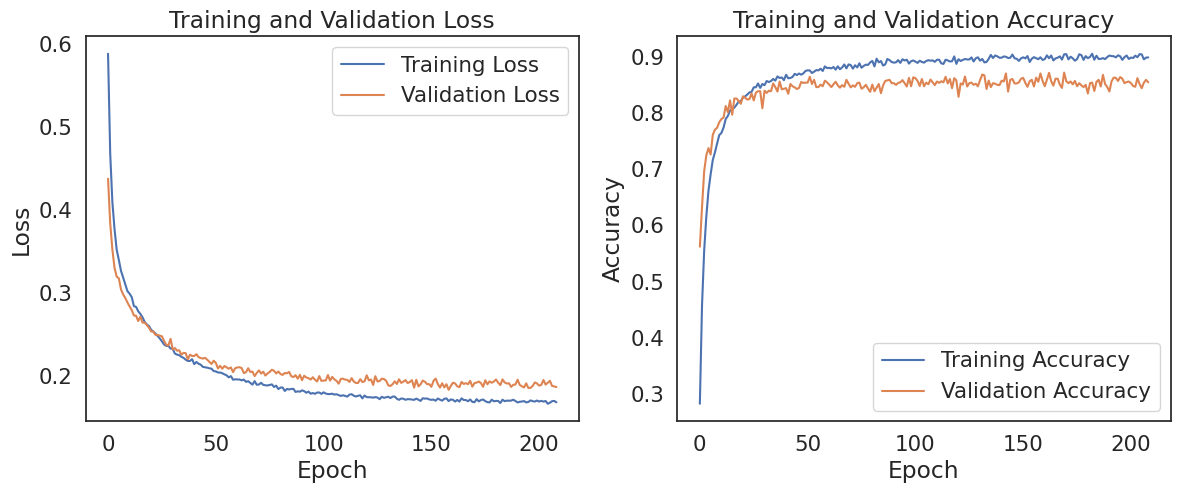

Epoch 209 : Learning rate = 2.4938751153058547e-07
357/357 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - categorical_accuracy: 0.9021 - loss: 0.1679 - val_categorical_accuracy: 0.8543 - val_loss: 0.1867


In [22]:
# Train the model with early stopping callback
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=callbacks
).history

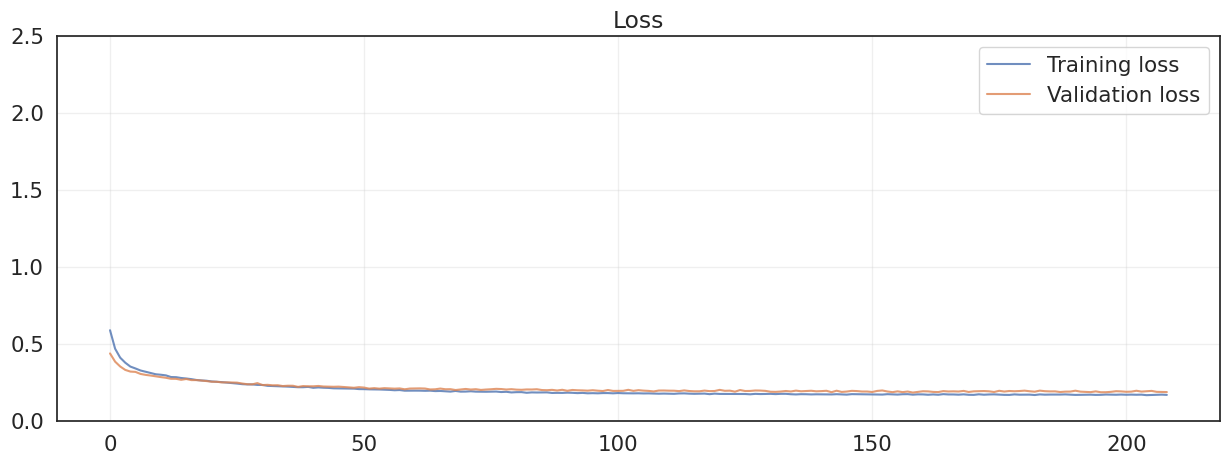

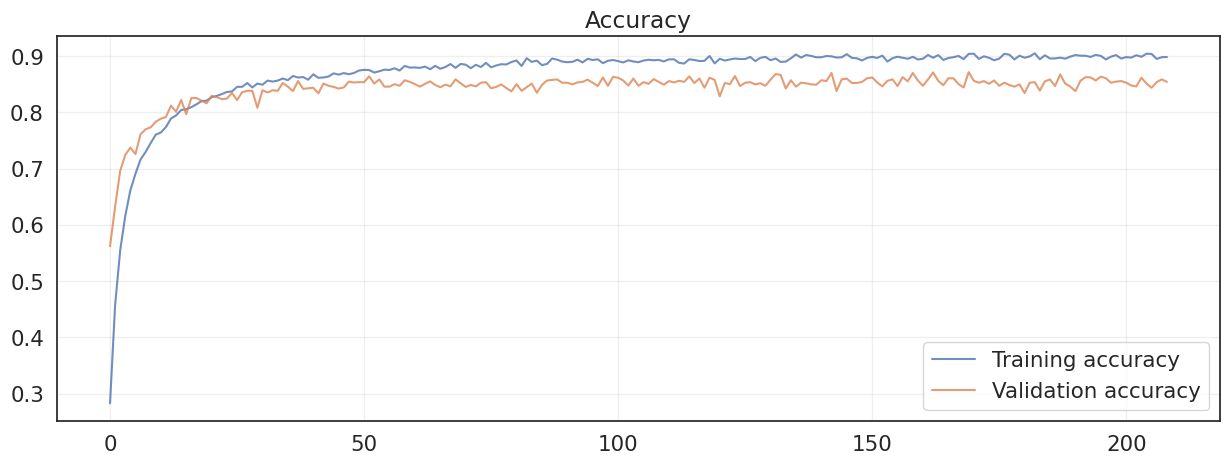

In [23]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.ylim(top=2.5, bottom=0.0)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 5))
plt.plot(history['categorical_accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_categorical_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'ADAM_HEAVY_AUG_MODEL.weights.h5'
    model.save_weights(model_weights_filename)

In [25]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
def evaluations(model, ds, y_ds, labels, name):
    # Predict class probabilities and get predicted classes
    ds_predictions = model.predict(ds, verbose=0)
    ds_predictions = np.argmax(ds_predictions, axis=-1)
    
    # Extract ground truth classes
    ds_gt = np.argmax(y_ds, axis=-1)
    
    # Calculate and display training set accuracy
    ds_accuracy = accuracy_score(ds_gt, ds_predictions)
    print(f'Accuracy score over the {name} set: {round(ds_accuracy, 4)}')
    
    # Calculate and display training set precision
    ds_precision = precision_score(ds_gt, ds_predictions, average='weighted')
    print(f'Precision score over the {name} set: {round(ds_precision, 4)}')
    
    # Calculate and display training set recall
    ds_recall = recall_score(ds_gt, ds_predictions, average='weighted')
    print(f'Recall score over the {name} set: {round(ds_recall, 4)}')
    
    # Calculate and display training set F1 score
    ds_f1 = f1_score(ds_gt, ds_predictions, average='weighted')
    print(f'F1 score over the {name} set: {round(ds_f1, 4)}')
    
    # Compute the confusion matrix
    cm = confusion_matrix(ds_gt, ds_predictions)
    
    # Create labels combining confusion matrix values
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)
    
    # Plot the confusion matrix with class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

2024-11-23 20:46:24.980860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node TF-CNN_1/BatchNorm_After_ConvNeXt_1/Cast_1/ReadVariableOp.


I0000 00:00:1732394785.525943     843 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b18dcaf78c9e46f7:0:0), session_name()


I0000 00:00:1732394792.334148     843 tpu_compile_op_common.cc:245] Compilation of b18dcaf78c9e46f7:0:0 with session name  took 6.808136055s and succeeded
I0000 00:00:1732394792.353376     843 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b18dcaf78c9e46f7:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14375624191044568315", property.function_library_fingerprint = 8745602676002430289, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732394792.353409     843 tpu_compilation_cache_interface.cc:541] After adding entry for key b18dcaf78c9

I0000 00:00:1732394819.262617     867 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(fd88a18ab3d33ea2:0:0), session_name()


I0000 00:00:1732394824.921605     867 tpu_compile_op_common.cc:245] Compilation of fd88a18ab3d33ea2:0:0 with session name  took 5.658949555s and succeeded
I0000 00:00:1732394824.943253     867 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fd88a18ab3d33ea2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_16797504581807608377", property.function_library_fingerprint = 7734742469726610831, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732394824.943280     867 tpu_compilation_cache_interface.cc:541] After adding entry for key 

Accuracy score over the validation set: 0.8553
Precision score over the validation set: 0.8561
Recall score over the validation set: 0.8553
F1 score over the validation set: 0.8556


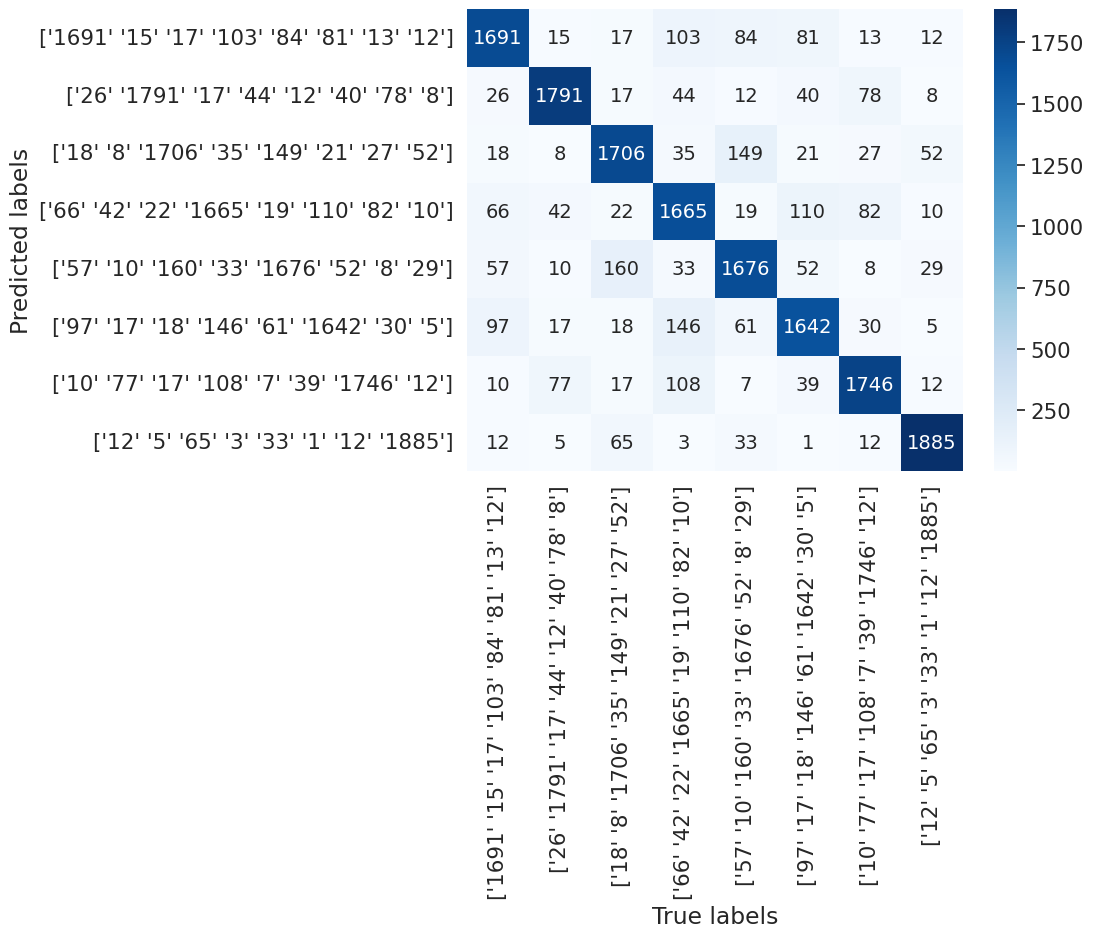

In [27]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')

In [28]:
# Get the weights of the last two dense layers and the output layer
dense_layer_1_weights = model.get_layer('Dense_layer_0').get_weights()
dense_layer_2_weights = model.get_layer('Dense_layer_1').get_weights()
dense_layer_3_weights = model.get_layer('Dense_layer_2').get_weights()
output_layer_weights = model.get_layer('output_layer').get_weights()

# Save the weights to files
np.savez('dense_layer_1_weights.npz', *dense_layer_1_weights)
np.savez('dense_layer_2_weights.npz', *dense_layer_2_weights)
np.savez('dense_layer_3_weights.npz', *dense_layer_3_weights)
np.savez('output_layer_weights.npz', *output_layer_weights)

## Fine tunning

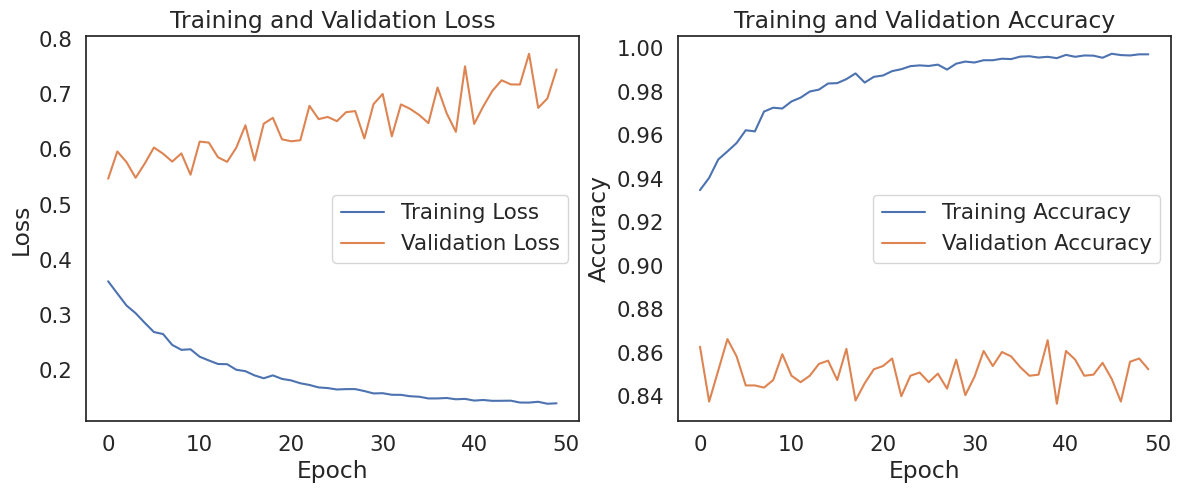

Epoch 50 : Learning rate = 9.999999747378752e-06
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - categorical_accuracy: 0.9975 - loss: 0.1394 - val_categorical_accuracy: 0.8523 - val_loss: 0.7449


In [29]:
model.get_layer('convnext_xlarge').trainable = True  # Base model

# Unfreeze only specific layers
trainable_layers_count = 0
for layer in model.get_layer('convnext_xlarge').layers:
    if 'stage_4' in layer.name or 'stage_3' in layer.name:  # Adjust based on architecture
        layer.trainable = True
        trainable_layers_count+=1
    else:
        layer.trainable = False

print(trainable_layers_count)

# Replace Dropout layers with higher rates
def increase_dropout(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = new_rate
    return model

model = increase_dropout(model, new_rate=0)

with strategy.scope():
    # Recompile with weight decay
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),  # Adjust weight decay here
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    shuffle=True,
    callbacks=callbacks
)

In [30]:
# Save the trained model to a file with the accuracy included in the filename
with strategy.scope():
    model_weights_filename = 'FINE_ADAM_HEAVY_AUG_MODEL.weights.h5'
    model.save_weights(model_weights_filename)

2024-11-23 21:17:50.298384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node TF-CNN_1/BatchNorm_After_ConvNeXt_1/Cast_1/ReadVariableOp.


I0000 00:00:1732396670.898916     867 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c398e4c21c2c70ff:0:0), session_name()


I0000 00:00:1732396677.376954     867 tpu_compile_op_common.cc:245] Compilation of c398e4c21c2c70ff:0:0 with session name  took 6.4779754s and succeeded
I0000 00:00:1732396677.398167     867 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c398e4c21c2c70ff:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_18296388503128670830", property.function_library_fingerprint = 7246505850851869010, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732396677.398201     867 tpu_compilation_cache_interface.cc:541] After adding entry for key c398e4c21c2c7

I0000 00:00:1732396705.930819     892 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1a7d0a3abaf08963:0:0), session_name()


I0000 00:00:1732396711.820052     892 tpu_compile_op_common.cc:245] Compilation of 1a7d0a3abaf08963:0:0 with session name  took 5.889190757s and succeeded
I0000 00:00:1732396711.841947     892 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1a7d0a3abaf08963:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2500384922677742009", property.function_library_fingerprint = 9975352142156160349, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732396711.841986     892 tpu_compilation_cache_interface.cc:541] After adding entry for key 1

Accuracy score over the validation set: 0.8535
Precision score over the validation set: 0.8535
Recall score over the validation set: 0.8535
F1 score over the validation set: 0.8534


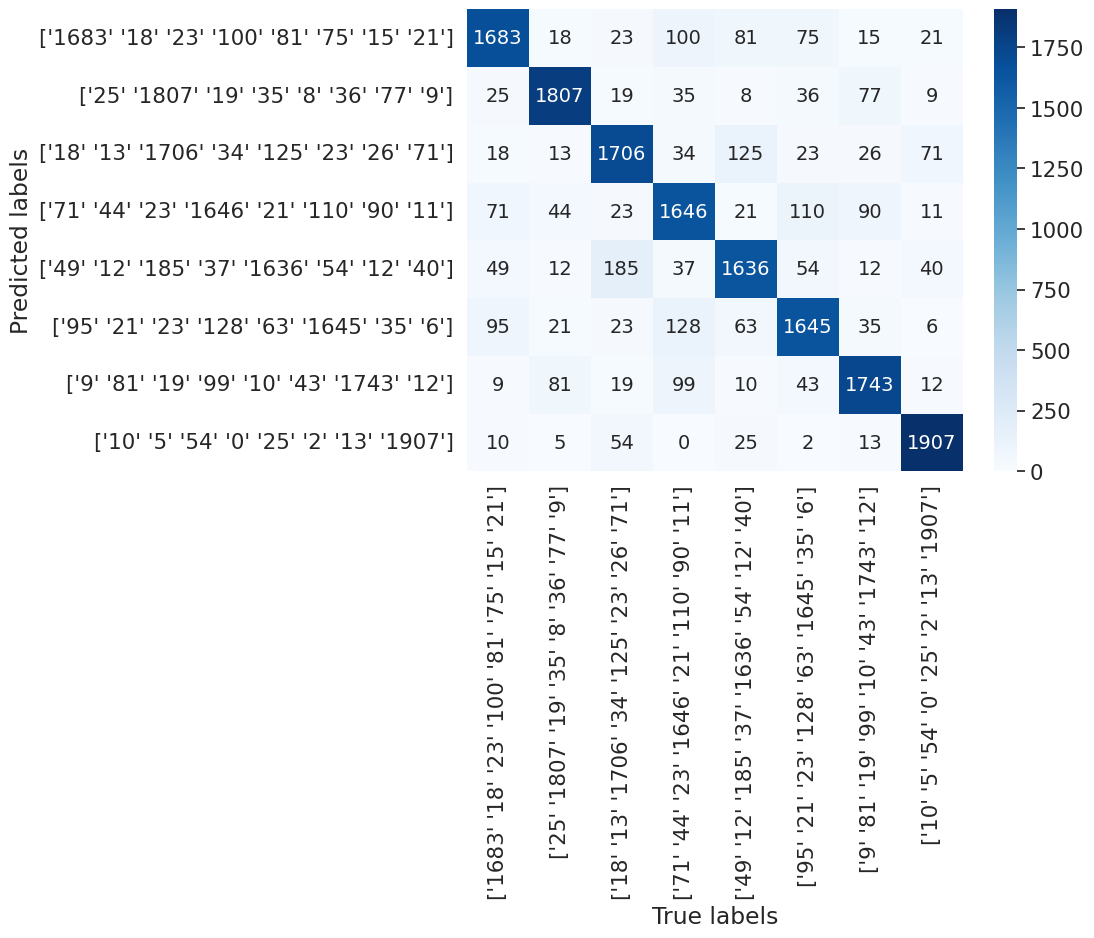

In [31]:
evaluations(model, ds=X_val, y_ds=y_val, labels=LABELS, name='validation')